In [1]:
import pandas as pd

def get_site_attr(site_name, attr):
    basic_info_df = pd.read_csv('generated\\data\\parkings_info.csv')
    return basic_info_df.loc[basic_info_df.parking_name == site_name].iloc[0][attr]

In [73]:
import pandas as pd
import glob
from shutil import copyfile

folders = glob.glob('generated\\week\\2000*')
lines = []
for folder in folders:
    full = glob.glob(folder+'\\raw_*')[0].split('_')
    target = full[0][19:]
    area = full[5:-1]
    path = 'D:/data/generated/'+target+'_compare_all_2000.png'
    copyfile(folder+'\\compare_all_2000.png', path)
    for sub in area:
        lines.append([target, sub, get_site_attr(sub,'total_space'),
                      get_site_attr(sub,'monthly_fee'), get_site_attr(sub,'building_type'),
                     0,0,path])

df = pd.DataFrame(lines)
df.columns = ['target', 'area', 'total_space', 'monthly_fee', 'building_type','corre','icorre','result']

In [74]:
df.to_excel('./correlation_analysis.xlsx')

In [41]:
jpgFilenamesList

['generated/week\\2000万山珠宝工业园_True_3_5376_1609284399.7520025',
 'generated/week\\2000万达丰大厦_True_14_5376_1609200082.5138874',
 'generated/week\\2000东翠花园_True_2_5376_1609156489.6720402',
 'generated/week\\2000中信星光明庭管理处_True_9_5376_1609235944.7706044',
 'generated/week\\2000中深石化大厦_True_2_5376_1609228667.1645172',
 'generated/week\\2000丰园酒店_True_10_5376_1609168857.3625247',
 'generated/week\\2000化工大厦_True_3_5376_1609187166.1566265',
 'generated/week\\2000华瑞大厦_True_4_5376_1609256379.276467',
 'generated/week\\2000同乐大厦_True_9_5376_1609263244.0220852',
 'generated/week\\2000天元大厦_True_9_5376_1609193393.997863',
 'generated/week\\2000文锦广场_True_9_5376_1609207148.6420422',
 'generated/week\\2000新白马_True_11_5376_1609270182.9053128',
 'generated/week\\2000桂龙家园_True_4_5376_1609291617.3268278',
 'generated/week\\2000武警生活区银龙花园_True_2_5376_1609221575.952158',
 'generated/week\\2000永新商业城_True_9_5376_1609214328.745912',
 'generated/week\\2000洪涛大厦_True_8_5376_1609181199.2818165',
 'generated/week\\2000红围坊

INFO:tensorflow:Using local port 24416
INFO:tensorflow:Using local port 15951
INFO:tensorflow:Using local port 19512
INFO:tensorflow:Using local port 23949
INFO:tensorflow:Using local port 22510
INFO:tensorflow:Using local port 23345
INFO:tensorflow:Using local port 22500
INFO:tensorflow:Using local port 15858
INFO:tensorflow:Using local port 23513
INFO:tensorflow:Using local port 20931
2016-05-31 19:30:00 2016-10-04 23:00:00


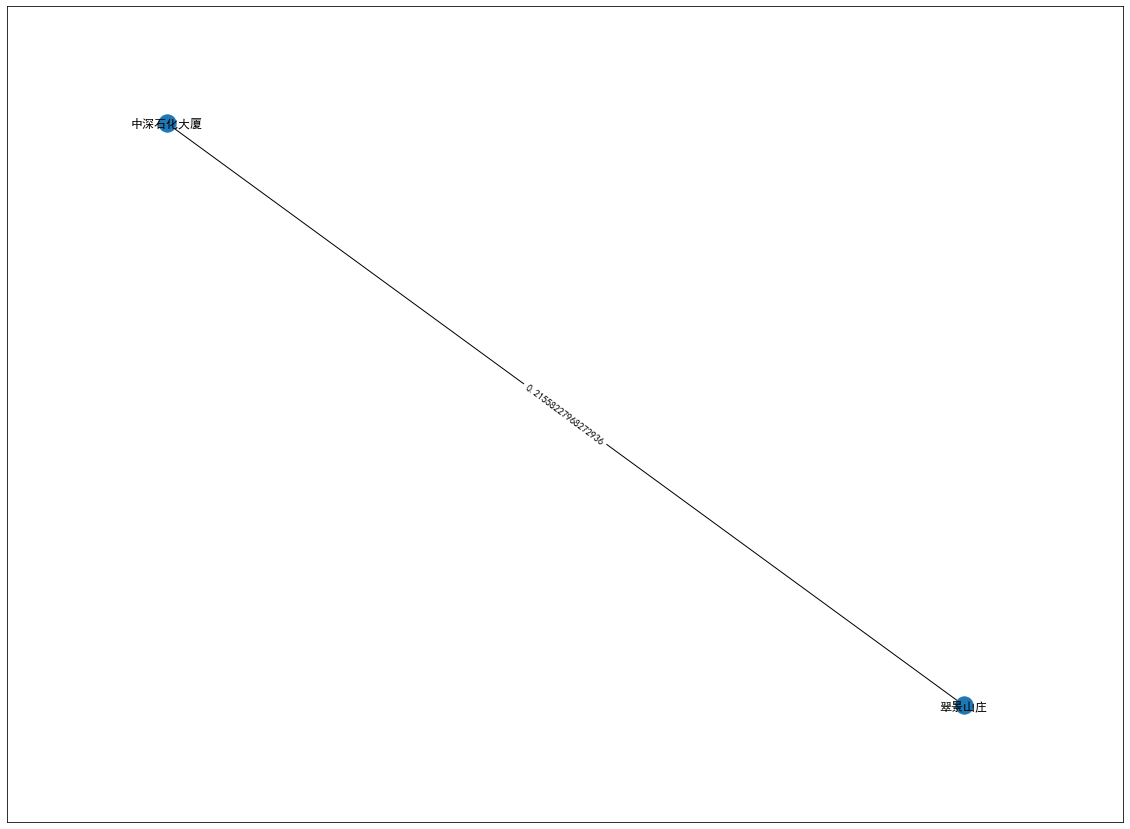

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import utils

plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams["figure.dpi"] = 90
plt.rcParams["font.size"] = 10
seqs_normal, adj, node_f, nks, conns, t_map = utils.init_data('翠景山庄')
df = pd.DataFrame(conns)
df.columns = ['s','t','w']

G = nx.from_pandas_edgelist(df, source='s', target='t', edge_attr='w')

lengths = [i['w'] for i in dict(G.edges).values()]
labels = {i:i for i in dict(G.nodes).keys()}

fig, ax = plt.subplots(figsize=(20,15))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, ax = ax, labels=True)
edge_labels = {e: G.edges[e]['w'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw_networkx_edges(G, pos, lengths=lengths,ax=ax)
_ = nx.draw_networkx_labels(G, pos, labels, ax=ax)
plt.margins(0.2, tight=False)

In [6]:
t_map

In [36]:
edge_labels

{('合正星园', '宝琳珠宝交易中心'): 0.260241298753267,
 ('合正星园', '湖景大厦'): 0.22962508076107815,
 ('宝琳珠宝交易中心', '湖景大厦'): 0.1573976435026092}

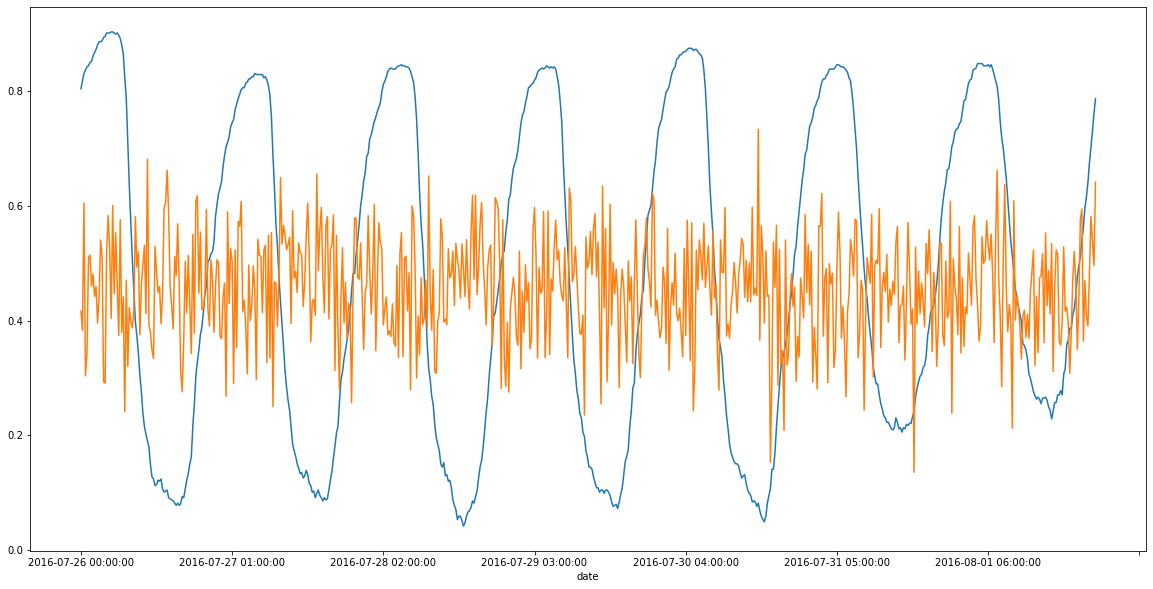

In [4]:
train_.seqs[1][0:96*7].plot(figsize=(20,10))
train_.seqs_noised[1][0:96*7].plot(figsize=(20,10))

In [40]:
from geopy import distance
import pandas as pd
import folium
import numpy as np


# build area for points near than max_dist to target
def d(target, max_dis, all_df):
    area_data = []
    for index, row in all_df.iterrows():
        if distance.distance(row.lat_long, target.lat_long).km < max_dis:
            area_data.append(row.values.tolist())

    return pd.DataFrame(area_data, columns=all_df.columns.values.tolist())


# build connection between points with length ---- not near than max_dist
def build_adj_matrix(area, max_dist=0.5):
    adj_matrix = []
    name_key_dict = dict()
    key_name_dict = dict()
    conns = []
    key = 0
    for lat1, long1, name1 in zip(area.latitude, area.longitude, area.parking_name):
        name_key_dict[name1] = key
        key_name_dict[key] = name1
        key += 1
        one_line = []
        for lat2, long2, name2 in zip(area.latitude, area.longitude, area.parking_name):
            if name1 != name2:  # and distance.distance((lat1, long1), (lat2, long2)).km < max_dist:
                dist = distance.distance((lat1, long1), (lat2, long2)).km
                one_line.append(dist)
                conns.append([name1, name2, dist])
            else:
                one_line.append(0)
        adj_matrix.append(one_line)
    return adj_matrix, name_key_dict, key_name_dict, conns


def build_adj_map(target, area_, adj_mat, key_names, name_keys):
    # Instantiate a feature group for the parkings in the dataframe
    parkings = folium.map.FeatureGroup()

    # Loop through and add each to the parkings feature group
    for lat, lng, name in zip(area_.latitude, area_.longitude, area_.parking_name):
        parkings.add_child(
            folium.CircleMarker(
                [lat, lng],
                radius=5,  # define how big you want the circle markers to be
                color='yellow',
                fill=True,
                fill_color=('red' if name == target.parking_name else 'green'),
                fill_opacity=0.6,
                popup=name,
                encode='uft-8'))
        neighbor_index = 0
        for is_neighbor in adj_mat[name_keys[name]]:
            if is_neighbor == 1:
                start = (lat, lng)
                end_parking = area_.loc[area_["parking_name"] == key_names[neighbor_index]].iloc[0]
                end = (end_parking.latitude, end_parking.longitude)
                parkings.add_child(folium.PolyLine([start, end], color="blue", weight=1.5, opacity=0.2))
            neighbor_index += 1

    luohu_map = folium.Map(location=[target.latitude, target.longitude], zoom_start=16)
    luohu_map.add_child(parkings)
    return luohu_map


def build_graph(basic_info_df, parking_name, max_dis=0.2, conn_coe=3 / 4):
    target_parking = basic_info_df.loc[basic_info_df.parking_name == parking_name].iloc[0]
    area = get_area(target_parking, max_dis, basic_info_df)
    adj_mat, nks, kns, conns = build_adj_matrix(area, max_dis * conn_coe)
    target_map = build_adj_map(target_parking, area, adj_mat, kns, nks)
    return area, np.mat(adj_mat), target_map, nks, kns, conns


In [15]:
import os
import pandas as pd
import re
from tqdm import tqdm

basic_info_df = pd.read_csv('generated/data/parkings_info.csv')
basic_info_df.longitude-=0.0064
basic_info_df.latitude-=0.0064
basic_info_df['lat_long'] = list(zip(basic_info_df['latitude'], basic_info_df['longitude']))

In [16]:
from IPython.display import Image, display
from datetime import date, timedelta
import pandas as pd
import numpy as np

def build_area_seqs(target_area, start='2016-08-01', end='2017-01-01'):
    # 整合到一个文件中
    area_df = pd.DataFrame()
    for name in target_area.parking_name:
        file_name = 'generated/data/seqs/'+name+'_seq.csv'
        file_df = pd.read_csv(file_name)
        file_df['parking'] = nks[name]
        cols = file_df.columns.tolist()
        cols = [cols[0], cols[2], cols[1]]
        file_df = file_df[cols]
        if len(area_df) > 0:
            area_df = pd.concat([area_df, file_df])
        else:
            area_df = file_df

    out_bound_indexes = area_df[(area_df['date'] < start) | (area_df['date'] >= end)].index 
    area_df.drop(out_bound_indexes, inplace = True) 
    return area_df.pivot_table('occupy', ['date'], 'parking')

In [17]:
# from graph_utils import build_graph

target_park = '华瑞大厦'
target_area, adj, target_map, nks, kns, _ = build_graph(basic_info_df, target_park)
target_park_basic_info = basic_info_df.loc[basic_info_df.parking_name == target_park].iloc[0]

#seqs_raw = build_area_seqs(target_area, start='2016-10-01', end='2016-11-01')
# normalization
# seqs_normal = seqs_raw/seqs_raw.max()

In [60]:
import os
import pandas as pd
import re
from tqdm import tqdm

basic_info_df = pd.read_csv('generated/data/parkings_info.csv')
basic_info_df.longitude-=0.0116
basic_info_df.latitude-=0.0038
basic_info_df['lat_long'] = list(zip(basic_info_df['latitude'], basic_info_df['longitude']))
target_park = '华润万象城'
target_area, adj, target_map, nks, kns, _ = build_graph(basic_info_df, target_park)
target_park_basic_info = basic_info_df.loc[basic_info_df.parking_name == target_park].iloc[0]

In [61]:
target_map

In [19]:
target_park_basic_info

parking_name                        华瑞大厦
latitude                         22.5361
longitude                        114.109
total_space                          158
monthly_fee                          250
building_type                         商业
lat_long         (22.536112, 114.109444)
Name: 23, dtype: object

In [5]:
def get_nodes_features(area_df):
    node_f = area_df[['total_space','monthly_fee','building_type']]
    node_f['total_space'] = node_f.total_space/node_f.total_space.max()
    node_f['monthly_fee'] = node_f.monthly_fee/node_f.monthly_fee.max()
    building_type_oneHot = pd.get_dummies(node_f['building_type'])
    node_f = node_f.drop('building_type',axis = 1)
    node_f = node_f.join(building_type_oneHot)
    return node_f

In [6]:
node_f = get_nodes_features(target_area)

/home/mark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [29]:
import tensorflow as tf
from abc import ABC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, GRU, Flatten, Dense, LeakyReLU
from spektral.layers import GraphConv

l2_reg = 5e-4 / 2  # L2 regularization rate


class Generator(Model, ABC):

    def __init__(self, adj, nodes_features):
        super(Generator, self).__init__()
        self.adj = adj
        self.nodes_features = nodes_features

        self.dropout = Dropout(0.5)
        self.flatten = Flatten()
        self.graph_conv_1 = GraphConv(32,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.graph_conv_2 = GraphConv(16,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(128, activation='relu')
        self.gru = GRU(128, return_sequences=True)
        self.final_dense = Dense(1, activation='tanh')

    def call(self, seq, training=True):
        f = tf.convert_to_tensor(self.nodes_features)  # 11*F
        g = tf.convert_to_tensor(self.adj)  # 11*11
        s = tf.convert_to_tensor(seq)  # 96*11

        c = self.graph_conv_1([f, g])  # 11*11
        c = self.graph_conv_2([c, g])  # 11*11
        s = tf.matmul(s, c)  # 96*11

        fc = self.dense_1(s)  # 96*32
        fc = self.dropout(fc, training=training)
        fc = self.dense_2(fc)  # 96*32
        fc = self.dropout(fc, training=training)

        fc = tf.expand_dims(fc, axis=0)  # 1*96*32
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0)  # 96*32
        return self.final_dense(ro)  # 96*1


class Discriminator(Model, ABC):

    def __init__(self, adj, nodes_features):
        super(Discriminator, self).__init__()
        self.adj = adj
        self.nodes_features = nodes_features

        self.leaky_relu = LeakyReLU(alpha=0.2)
        self.dropout = Dropout(0.5)
        self.flatten = Flatten()
        self.graph_conv_1 = GraphConv(32,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.graph_conv_2 = GraphConv(16,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.dense_1 = Dense(64)
        self.dense_2 = Dense(128)
        self.gru = GRU(128, return_sequences=True)
        self.final_dense = Dense(1, activation='sigmoid')

    def call(self, seq, training=True):
        f = tf.convert_to_tensor(self.nodes_features)  # 11*F
        g = tf.convert_to_tensor(self.adj)  # 11*11
        s = tf.convert_to_tensor(seq)  # 96*11

        c = self.graph_conv_1([f, g])  # 11*11
        c = self.graph_conv_2([c, g])  # 11*11
        s = tf.matmul(s, c)  # 96*11

        fc = self.dense_1(s)  # 96*32
        fc = self.leaky_relu(fc)
        fc = self.dropout(fc, training=training)
        fc = self.dense_2(fc)  # 96*64
        fc = self.leaky_relu(fc)
        fc = self.dropout(fc, training=training)

        fc = tf.expand_dims(fc, axis=0)
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0)  # 96*64
        return self.final_dense(ro)  # 96*1


In [30]:
import os
from tensorflow.keras.optimizers import Adam
from spektral.utils import normalized_laplacian
# from model import Generator, Discriminator
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

batch_size = 96
save_interval = 5
learning_rate = 2e-3
adam_beta_1 = 0.6


class Train:
    def __init__(self, seqs, adj, nodes_features, epochs=1000, key=9):
        self.epochs = epochs
        self.seqs = seqs.astype('float32')

        self.gen_optimizer = Adam(learning_rate, adam_beta_1)
        self.desc_optimizer = Adam(learning_rate, adam_beta_1)

        self.adj = normalized_laplacian(adj.astype('float32'))
        self.nodes_features = nodes_features.astype('float32')
        self.generator = Generator(self.adj, self.nodes_features)
        self.discriminator = Discriminator(self.adj, self.nodes_features)

        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        self.key = key

    def __call__(self, epochs=None ,save_path='generated/saved'):
        save_path += str(time.time())
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        if epochs is None:
            epochs = self.epochs
            
        time_len = self.seqs.shape[0]
        num_nodes = self.seqs.shape[1]
        total_batch = int(time_len / batch_size)  # 2976/96=31

        time_consumed_total = 0.
        for epoch in range(1, epochs + 1):
            start = time.time()
            total_gen_loss = 0
            total_disc_loss = 0

            for week in range(0, total_batch):
                current_seqs = self.seqs[week*batch_size:week*batch_size + batch_size]
                seqs_noised = current_seqs.copy()
                max_s = current_seqs[self.key].max()
                seqs_noised[self.key] = np.random.normal(max_s / 2.0, max_s / 10.0,
                                                         size=(current_seqs.shape[0])).astype('float32')
                gen_loss, disc_loss = self.train_step(current_seqs, seqs_noised)
                total_gen_loss += gen_loss
                total_disc_loss += disc_loss

            time_consumed = time.time() - start
            time_consumed_total += time_consumed
            time_consumed_agv = time_consumed_total / epoch
            epochs_last = epochs - epoch
            estimate_time_last = epochs_last * time_consumed_agv
            print('epoch {}({})/{}({}) - gen_loss = {}, disc_loss = {}, estimated to finish: {}'
                  .format(epoch, round(time.time() - start, 2),
                          epochs, round(time_consumed_total, 2),
                          round(float(total_gen_loss / total_batch), 5),
                          round(float(total_disc_loss / total_batch), 5),
                          round(estimate_time_last, 2)))

            if epoch % save_interval == 0:
                plot = self.generate().plot()
                fig = plot.get_figure()
                fig.savefig(save_path + "/gen_" + str(epoch) + ".png")
                plt.clf()

    @tf.function
    def train_step(self, seqs, seqs_noised):
        with tf.GradientTape(persistent=True) as tape:
            real_output = self.discriminator(seqs)  # 评价高
            generated = self.generator(seqs_noised)
            left = tf.slice(seqs, [0, 0], [batch_size, self.key])
            right = tf.slice(seqs, [0, self.key + 1], [batch_size, -1])
            combined = tf.concat([left, generated, right], 1)
            generated_output = self.discriminator(combined)  # 初始评价低

            loss_g = self.generator_loss(self.cross_entropy, generated_output)
            loss_d = self.discriminator_loss(self.cross_entropy, real_output, generated_output)

        grad_gen = tape.gradient(loss_g, self.generator.trainable_variables)
        grad_disc = tape.gradient(loss_d, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(grad_gen, self.generator.trainable_variables))
        self.desc_optimizer.apply_gradients(zip(grad_disc, self.discriminator.trainable_variables))

        return loss_g, loss_d

    def generate(self):
        import random as random
        week = 1 # random.randint(0,31)
        seqs_replace = self.seqs[week*batch_size:week*batch_size + batch_size].copy()
        max_s = seqs_replace[self.key].max()
        seqs_replace[self.key] = np.random.normal(max_s / 2.0, max_s / 10.0, size=(seqs_replace.shape[0])).astype(
            'float32')
        gen_data = self.generator(seqs_replace, training=False)

        from sklearn import preprocessing
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(gen_data.numpy())
        return pd.DataFrame(x_scaled) # [self.key]

    @staticmethod
    def discriminator_loss(loss_object, real_output, fake_output):
        """
        ...
        """
        real_loss = loss_object(tf.ones_like(real_output), real_output)
        fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @staticmethod
    def generator_loss(loss_object, fake_output):
        """
        ...
        """
        return loss_object(tf.ones_like(fake_output), fake_output)

In [31]:
train = Train(seqs_normal, adj, node_f, 1500, 9)
train()

epoch 1(2.93)/1500(2.93) - gen_loss = 0.58916, disc_loss = 1.38942, estimated to finish: 4391.13
epoch 2(0.76)/1500(3.69) - gen_loss = 0.58663, disc_loss = 1.39429, estimated to finish: 2764.06
epoch 3(0.8)/1500(4.49) - gen_loss = 0.52124, disc_loss = 1.39462, estimated to finish: 2241.22
epoch 4(0.77)/1500(5.26) - gen_loss = 0.57692, disc_loss = 1.38174, estimated to finish: 1966.6
epoch 5(0.77)/1500(6.03) - gen_loss = 0.34074, disc_loss = 1.65846, estimated to finish: 1802.69
epoch 6(0.78)/1500(6.81) - gen_loss = 0.31338, disc_loss = 1.62676, estimated to finish: 1694.96
epoch 7(0.76)/1500(7.56) - gen_loss = 0.31334, disc_loss = 1.6267, estimated to finish: 1613.11
epoch 8(0.75)/1500(8.32) - gen_loss = 0.31331, disc_loss = 1.62661, estimated to finish: 1551.18
epoch 9(0.76)/1500(9.08) - gen_loss = 0.31333, disc_loss = 1.62662, estimated to finish: 1503.75
epoch 10(0.76)/1500(9.84) - gen_loss = 0.31334, disc_loss = 1.62653, estimated to finish: 1465.64
epoch 11(0.77)/1500(10.61) - gen

epoch 85(0.76)/1500(71.29) - gen_loss = 0.63944, disc_loss = 1.37767, estimated to finish: 1186.75
epoch 86(0.76)/1500(72.05) - gen_loss = 0.64537, disc_loss = 1.37859, estimated to finish: 1184.69
epoch 87(0.76)/1500(72.81) - gen_loss = 0.68184, disc_loss = 1.38826, estimated to finish: 1182.56
epoch 88(0.76)/1500(73.57) - gen_loss = 0.67941, disc_loss = 1.37847, estimated to finish: 1180.45
epoch 89(0.75)/1500(74.32) - gen_loss = 0.63366, disc_loss = 1.39421, estimated to finish: 1178.31
epoch 90(0.77)/1500(75.09) - gen_loss = 0.67463, disc_loss = 1.38327, estimated to finish: 1176.41
epoch 91(0.78)/1500(75.87) - gen_loss = 0.6547, disc_loss = 1.38454, estimated to finish: 1174.66
epoch 92(0.76)/1500(76.62) - gen_loss = 0.66099, disc_loss = 1.38206, estimated to finish: 1172.68
epoch 93(0.76)/1500(77.38) - gen_loss = 0.62824, disc_loss = 1.37557, estimated to finish: 1170.67
epoch 94(0.75)/1500(78.13) - gen_loss = 0.64749, disc_loss = 1.38136, estimated to finish: 1168.63
epoch 95(0.

/home/mark/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


epoch 106(0.87)/1500(88.0) - gen_loss = 0.62338, disc_loss = 1.36979, estimated to finish: 1157.31
epoch 107(0.78)/1500(88.78) - gen_loss = 0.68487, disc_loss = 1.38642, estimated to finish: 1155.79
epoch 108(0.84)/1500(89.62) - gen_loss = 0.68695, disc_loss = 1.38526, estimated to finish: 1155.13
epoch 109(0.82)/1500(90.44) - gen_loss = 0.68394, disc_loss = 1.38595, estimated to finish: 1154.12
epoch 110(0.84)/1500(91.28) - gen_loss = 0.68268, disc_loss = 1.38579, estimated to finish: 1153.44
epoch 111(0.76)/1500(92.04) - gen_loss = 0.67148, disc_loss = 1.38494, estimated to finish: 1151.75
epoch 112(0.76)/1500(92.8) - gen_loss = 0.67248, disc_loss = 1.38337, estimated to finish: 1150.0
epoch 113(0.75)/1500(93.54) - gen_loss = 0.65417, disc_loss = 1.38329, estimated to finish: 1148.18
epoch 114(0.75)/1500(94.3) - gen_loss = 0.65497, disc_loss = 1.38408, estimated to finish: 1146.46
epoch 115(0.77)/1500(95.07) - gen_loss = 0.6528, disc_loss = 1.37904, estimated to finish: 1144.94
epoch

epoch 188(0.83)/1500(153.56) - gen_loss = 0.64201, disc_loss = 1.34198, estimated to finish: 1071.64
epoch 189(0.77)/1500(154.33) - gen_loss = 0.64502, disc_loss = 1.38158, estimated to finish: 1070.5
epoch 190(0.77)/1500(155.09) - gen_loss = 0.66365, disc_loss = 1.35182, estimated to finish: 1069.33
epoch 191(0.91)/1500(156.0) - gen_loss = 0.65196, disc_loss = 1.36635, estimated to finish: 1069.15
epoch 192(0.79)/1500(156.79) - gen_loss = 0.65212, disc_loss = 1.36792, estimated to finish: 1068.13
epoch 193(0.8)/1500(157.59) - gen_loss = 0.66136, disc_loss = 1.36518, estimated to finish: 1067.19
epoch 194(0.8)/1500(158.39) - gen_loss = 0.65638, disc_loss = 1.37393, estimated to finish: 1066.3
epoch 195(0.8)/1500(159.19) - gen_loss = 0.67005, disc_loss = 1.36679, estimated to finish: 1065.34
epoch 196(0.82)/1500(160.01) - gen_loss = 0.65362, disc_loss = 1.36336, estimated to finish: 1064.54
epoch 197(0.8)/1500(160.8) - gen_loss = 0.67315, disc_loss = 1.3778, estimated to finish: 1063.59

epoch 270(0.8)/1500(219.4) - gen_loss = 0.59965, disc_loss = 1.34248, estimated to finish: 999.49
epoch 271(0.79)/1500(220.19) - gen_loss = 0.655, disc_loss = 1.31814, estimated to finish: 998.57
epoch 272(0.78)/1500(220.96) - gen_loss = 0.64699, disc_loss = 1.2504, estimated to finish: 997.59
epoch 273(0.87)/1500(221.84) - gen_loss = 0.66454, disc_loss = 1.21483, estimated to finish: 997.05
epoch 274(0.82)/1500(222.65) - gen_loss = 0.63878, disc_loss = 1.2702, estimated to finish: 996.25
epoch 275(0.84)/1500(223.49) - gen_loss = 0.62294, disc_loss = 1.30669, estimated to finish: 995.57
epoch 276(0.8)/1500(224.3) - gen_loss = 0.63788, disc_loss = 1.28027, estimated to finish: 994.7
epoch 277(0.83)/1500(225.13) - gen_loss = 0.61381, disc_loss = 1.30765, estimated to finish: 993.98
epoch 278(0.79)/1500(225.92) - gen_loss = 0.6374, disc_loss = 1.32676, estimated to finish: 993.06
epoch 279(0.8)/1500(226.72) - gen_loss = 0.61497, disc_loss = 1.33608, estimated to finish: 992.19
epoch 280(0

epoch 353(0.76)/1500(285.14) - gen_loss = 0.59719, disc_loss = 1.29331, estimated to finish: 926.52
epoch 354(0.78)/1500(285.93) - gen_loss = 0.62623, disc_loss = 1.27426, estimated to finish: 925.63
epoch 355(0.78)/1500(286.7) - gen_loss = 0.60171, disc_loss = 1.34417, estimated to finish: 924.72
epoch 356(0.77)/1500(287.47) - gen_loss = 0.68042, disc_loss = 1.19429, estimated to finish: 923.78
epoch 357(0.75)/1500(288.23) - gen_loss = 0.65127, disc_loss = 1.23464, estimated to finish: 922.8
epoch 358(0.76)/1500(288.98) - gen_loss = 0.66845, disc_loss = 1.17988, estimated to finish: 921.84
epoch 359(0.77)/1500(289.75) - gen_loss = 0.66086, disc_loss = 1.19223, estimated to finish: 920.9
epoch 360(0.77)/1500(290.52) - gen_loss = 0.6517, disc_loss = 1.18498, estimated to finish: 919.99
epoch 361(0.79)/1500(291.32) - gen_loss = 0.6374, disc_loss = 1.26798, estimated to finish: 919.14
epoch 362(0.81)/1500(292.13) - gen_loss = 0.65328, disc_loss = 1.22731, estimated to finish: 918.35
epoch

epoch 436(0.77)/1500(351.45) - gen_loss = 0.65069, disc_loss = 1.2155, estimated to finish: 857.66
epoch 437(0.79)/1500(352.24) - gen_loss = 0.65981, disc_loss = 1.17056, estimated to finish: 856.81
epoch 438(0.77)/1500(353.01) - gen_loss = 0.6235, disc_loss = 1.20529, estimated to finish: 855.92
epoch 439(0.77)/1500(353.77) - gen_loss = 0.67062, disc_loss = 1.14267, estimated to finish: 855.02
epoch 440(0.77)/1500(354.54) - gen_loss = 0.66569, disc_loss = 1.12222, estimated to finish: 854.12
epoch 441(0.77)/1500(355.31) - gen_loss = 0.67258, disc_loss = 1.1169, estimated to finish: 853.23
epoch 442(0.75)/1500(356.06) - gen_loss = 0.67045, disc_loss = 1.12447, estimated to finish: 852.29
epoch 443(0.76)/1500(356.83) - gen_loss = 0.66807, disc_loss = 1.11958, estimated to finish: 851.39
epoch 444(0.75)/1500(357.58) - gen_loss = 0.67465, disc_loss = 1.10418, estimated to finish: 850.45
epoch 445(0.77)/1500(358.35) - gen_loss = 0.66512, disc_loss = 1.11825, estimated to finish: 849.56
epo

epoch 519(0.78)/1500(417.32) - gen_loss = 0.633, disc_loss = 1.17229, estimated to finish: 788.82
epoch 520(0.8)/1500(418.13) - gen_loss = 0.66266, disc_loss = 1.18482, estimated to finish: 788.01
epoch 521(0.91)/1500(419.04) - gen_loss = 0.63463, disc_loss = 1.1983, estimated to finish: 787.4
epoch 522(0.75)/1500(419.79) - gen_loss = 0.66505, disc_loss = 1.17654, estimated to finish: 786.5
epoch 523(0.76)/1500(420.55) - gen_loss = 0.6729, disc_loss = 1.14309, estimated to finish: 785.61
epoch 524(0.78)/1500(421.33) - gen_loss = 0.64201, disc_loss = 1.17328, estimated to finish: 784.76
epoch 525(0.82)/1500(422.15) - gen_loss = 0.65405, disc_loss = 1.16596, estimated to finish: 783.99
epoch 526(0.81)/1500(422.95) - gen_loss = 0.67865, disc_loss = 1.11229, estimated to finish: 783.19
epoch 527(0.8)/1500(423.75) - gen_loss = 0.67287, disc_loss = 1.09595, estimated to finish: 782.37
epoch 528(0.81)/1500(424.56) - gen_loss = 0.67299, disc_loss = 1.07686, estimated to finish: 781.58
epoch 52

epoch 602(0.91)/1500(488.11) - gen_loss = 0.64867, disc_loss = 1.19611, estimated to finish: 728.12
epoch 603(0.81)/1500(488.92) - gen_loss = 0.66238, disc_loss = 1.16204, estimated to finish: 727.3
epoch 604(0.79)/1500(489.71) - gen_loss = 0.64483, disc_loss = 1.18892, estimated to finish: 726.46
epoch 605(0.79)/1500(490.5) - gen_loss = 0.65828, disc_loss = 1.17718, estimated to finish: 725.62
epoch 606(0.87)/1500(491.37) - gen_loss = 0.63986, disc_loss = 1.18909, estimated to finish: 724.89
epoch 607(0.88)/1500(492.25) - gen_loss = 0.6578, disc_loss = 1.16287, estimated to finish: 724.18
epoch 608(0.77)/1500(493.01) - gen_loss = 0.64234, disc_loss = 1.15794, estimated to finish: 723.3
epoch 609(0.82)/1500(493.83) - gen_loss = 0.65286, disc_loss = 1.12969, estimated to finish: 722.5
epoch 610(0.9)/1500(494.73) - gen_loss = 0.65109, disc_loss = 1.1362, estimated to finish: 721.82
epoch 611(0.9)/1500(495.63) - gen_loss = 0.61571, disc_loss = 1.24335, estimated to finish: 721.14
epoch 61

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [1]:
from matplotlib.pyplot import *
fig, ax = subplots()
fig.set_figheight(5)
fig.set_figwidth(10)
n=100
key=9
for w in range(0,n):
    seqs_normal[w:w+96][key].plot(ax=ax) 
# for w in range(1,n):
#     generated_seq = train.generate()
#     generated_seq.plot(ax=ax)
ax.legend(['real'+str(w) for w in range(1,n)]);# +['gen'+str(w) for w in range(1,n)]);

NameError: name 'seqs_normal' is not defined

In [3]:
import tensorflow as tf
fc=tf.convert_to_tensor([[0,3,6],
    [1,4,7],
    [2,5,8]])
tf.expand_dims(fc, axis=0)

<tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
array([[[0, 3, 6],
        [1, 4, 7],
        [2, 5, 8]]])>

In [24]:
import tensorflow as tf
import tensorflow.keras.layers as layers

fc=tf.convert_to_tensor([[0,3,6],
    [1,4,7],
    [2,5,8]])
layers. layers.Reshape((3,1),input_shape=(3,))(fc)

InvalidArgumentError: Input to reshape is a tensor with 9 values, but the requested shape has 27 [Op:Reshape]

In [10]:
(1,fc.shape[0],fc.shape[1])

(1, 3, 3)